**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Непараметрические криетрии

  Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки)  
  ------------- | -------------|
  **Знаков**  | $\times$ | | $\times$ 
  **Ранговый** | $\times$  | $\times$ | $\times$  
  **Перестановочный** | $\times$  | $\times$ | $\times$ 

## Терапия при анорексии

В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [1]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [2]:
import scipy
import statsmodels
print(np.__version__)
print(pd.__version__)
print(scipy.__version__)
print(statsmodels.__version__)

1.17.4
0.25.3
1.3.2
0.10.1


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [4]:
weight_data = pd.read_csv('weight.txt', sep = '\t', header = 0)

In [5]:
weight_data.head()

,Before,After
0,80.5,82.2
1,84.9,85.6
2,81.5,81.4
3,82.6,81.9
4,79.9,76.4


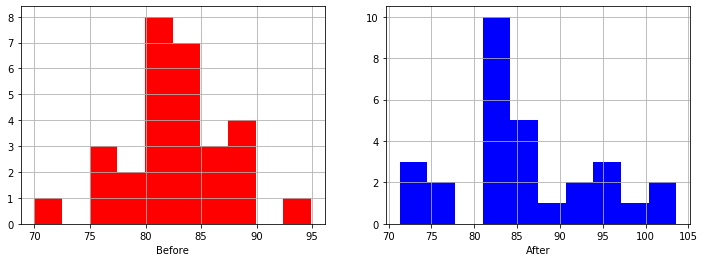

In [6]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(weight_data.Before, color = 'r')
pylab.xlabel('Before')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(weight_data.After, color = 'b')
pylab.xlabel('After')

pylab.show()

In [64]:
weight_data.describe()

,Before,After
count,29.000000,29.000000
mean,82.689655,85.696552
std,4.845495,8.351924
min,70.000000,71.300000
25%,80.400000,81.900000
50%,82.600000,83.900000
75%,85.000000,90.900000
max,94.900000,103.600000


## Двухвыборочные критерии для связных выборок

$H_0\colon$ медианы веса до и после терапии совпадает

$H_1\colon$ медианы веса до и после тепрапии отличаются

In [65]:
print('95%% confidence interval for mean weight before therapy: [%f, %f]' % zconfint(weight_data.Before))

95% confidence interval for mean weight before therapy: [80.926107, 84.453203]


In [66]:
print('95%% confidence interval for mean weight after therapy: [%f, %f]' % zconfint(weight_data.After))

95% confidence interval for mean weight after therapy: [82.656817, 88.736286]


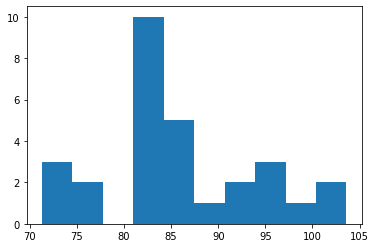

In [84]:
pylab.hist(weight_data.After)
pylab.show()

### Критерий знаков

$H_0\colon P\left(X_1>X_2\right)=\frac1{2},$

$H_1\colon P\left(X_1>X_2\right)\neq\frac1{2}$

In [7]:
arr = np.array([49,58,75,110,112,132,151,276,281,362])
print("M: %d, p-value: %f" % sign_test(arr))

M: 5, p-value: 0.001953


### Критерий знаковых рангов Уилкоксона

$H_0\colon med\left(X_1-X_2\right)=0,$

$H_1\colon med\left(X_1-X_2\right)\neq0$

In [9]:
stats.wilcoxon(weight_data.After, weight_data.Before)

WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)

In [10]:
stats.wilcoxon(arr-200)

WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)

### Перестановочный критерий

$H_0\colon \mathbb{E}(X_1 - X_2) = 0$

$H_1\colon \mathbb{E}(X_1 - X_2) \neq 0$

In [33]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(list(map(lambda x: x - mean, sample)))
    return t_stat

In [34]:
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = list(map(lambda x: x - mean, sample))
    if max_permutations:
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, 
                                                                              len(sample))) - 1 ])
    else:
        signs_array =  itertools.product([-1, 1], repeat = len(sample))
    distr = [sum(centered_sample * np.array(signs)) for signs in signs_array]
    return distr

C:\Users\kpebe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\kpebe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6744: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

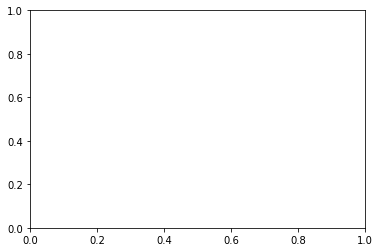

In [35]:
pylab.hist(permutation_zero_distr_1sample(df_damage - df_nodamage, 0., 
                               max_permutations = 10000))
pylab.show()

In [23]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_1sample(sample, mean)
    
    zero_distr = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [26]:
print("p-value: %f" % permutation_test(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 1000))

p-value: 0.038000


In [27]:
print("p-value: %f" % permutation_test(weight_data.After - weight_data.Before, 0., 
                               max_permutations = 50000))

p-value: 0.033941


In [14]:
df = pd.read_csv('challenger.txt', sep = '\t', engine = 'python')

In [17]:
def get_bootstrap_samples(sample1, sample2, n_samples):
    
    a = []
    b = []
    
    for i in range(n_samples):
    
        indices1 = np.random.randint(0, len(sample1), len(sample1))
        indices2 = np.random.randint(0, len(sample2), len(sample2))
    
        a.append(np.mean(np.array(sample1)[(indices1)]))
        b.append(np.mean(np.array(sample2)[(indices2)]))
    
    return a, b

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [26]:
df_nodamage = df['Temperature'][df['Incident'] == 0]
df_damage = df['Temperature'][df['Incident'] == 1]

In [27]:
np.random.seed(0)
a,b = get_bootstrap_samples(df_damage, df_nodamage, 1000)

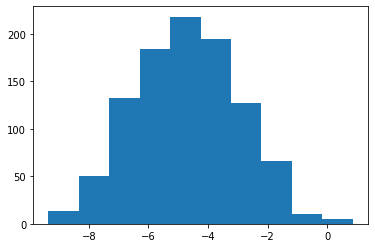

In [28]:
pylab.hist(np.array(a)-np.array(b))
pylab.show()

In [32]:
zconfint(np.array(a) - np.array(b), alpha = 0.05, ddof = 0, alternative = 'two-sided')

(-4.79986223984759, -4.583898474438122)